### Описание стратегии: 

парный арбитраж long/short - идентификация 2 компаний, которые имеют многолетние партнерства в одной отрасли, затем поиск момента, когда спрэд между акциями этих двух компаний расходится до уровня выше среднего, что является торговым сигналом к открытию сделки - одную компанию в лонг, другую в шорт . Как только спрэд сужается до среднего, нормального уровня - закрываем сделку. 

Не предусмотрено никаких стоп-лоссов, лимитных ордеров и так далее. Бэктест также не учитывает брокерские комиссии.
Расчет торгового сигнала принимается исходя из цены закрытия прошлого дня.

Преимущество такого типа стратегия является арбитраж в чистом виде, т.е. высокая вероятность прибыльности, поскольку рано или поздно спред всех сходится обратно, что делает такую стратегию прибыльной при любых рыночных условиях - не важно, акции идут вверх/вниз или находятся в боковике - стратегия стабильно генерирует прибыль.

### Пример:

Компания Lear производит автомобильные сидения и около 20% выручки компании приходится на General Motors, что объясняет высокую корреляцию между акциями этих двух компаний, что создает возможность для парной торговли:

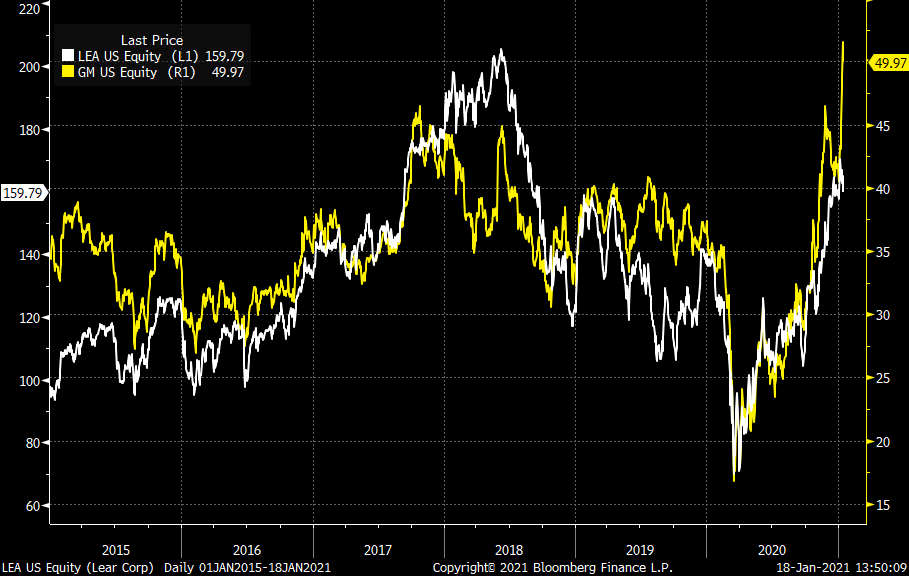

#### Загрузка необходимых пакетов

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import scipy.stats as stats
from collections import deque
from pykalman import KalmanFilter
from math import sqrt
%matplotlib inline

#### Для идентификации торгового сигнала и расчета расхождения спреда будет использовать фильтр Калмана (более подробно: https://habr.com/ru/post/166693/)

In [2]:
def KalmanFilterAverage(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)
  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

# Kalman filter regression

def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means


#считаем также оптимальное "окно" для расчета фильтра Калмана
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
    if halflife <= 0:
        halflife = 1
    return halflife

#### Фукнция для бэктеста:

In [3]:
def backtest(df, s1, s2):
        #############################################################
        # INPUT:
        # DataFrame of prices
        # s1: the symbol of contract one
        # s2: the symbol of contract two
        # x: the price series of contract one
        # y: the price series of contract two
        # OUTPUT:
        # df1['cum rets']: cumulative returns in pandas data frame
        # sharpe: Sharpe ratio
        # CAGR: Compound Annual Growth Rate
    
        x = df[s1]
        y = df[s2]
    
    # run regression (including Kalman Filter) to find hedge ratio and then create spread series
        df1 = pd.DataFrame({'y':y,'x':x})
        df1.index = pd.to_datetime(df1.index)
        state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))
        df1['hr'] = - state_means[:,0]
        df1['spread'] = df1.y + (df1.x * df1.hr)
    
    # calculate half life
        halflife = half_life(df1['spread'])
    
    # calculate z-score with window = half life period
        meanSpread = df1.spread.rolling(window=halflife).mean()
        stdSpread = df1.spread.rolling(window=halflife).std()
        df1['zScore'] = (df1.spread-meanSpread)/stdSpread
    ##############################################################
    
    # trading logic
        entryZscore = 1.5
        exitZscore = 0
    
    #set up num units long
        df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
        df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore))
        df1['num units long'] = np.nan 
        df1.loc[df1['long entry'],'num units long'] = 1 
        df1.loc[df1['long exit'],'num units long'] = 0 
        df1['num units long'][0] = 0 
        df1['num units long'] = df1['num units long'].fillna(method='pad') 
        
    #set up num units short
        df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
        df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
        df1.loc[df1['short entry'],'num units short'] = -1
        df1.loc[df1['short exit'],'num units short'] = 0
        df1['num units short'][0] = 0
        df1['num units short'] = df1['num units short'].fillna(method='pad')
        df1['numUnits'] = df1['num units long'] + df1['num units short']
     
    #calculate spread change and cumulative return
        df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hr'])) + df1['y'])
        df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)
        df1['cum rets'] = df1['port rets'].cumsum()
        df1['cum rets'] = df1['cum rets'] + 1
    
    ##############################################################
        try:
            sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
        except ZeroDivisionError:
            sharpe = 0.0
    
    ##############################################################
        start_val = 1
        end_val = df1['cum rets'].iat[-1]
        start_date = df1.iloc[0].name
        end_date = df1.iloc[-1].name
        days = (end_date - start_date).days
        CAGR = round(((float(end_val) / float(start_val)) ** (252.0/days)) - 1,4)
        df1[s1+ " "+s2] = df1['cum rets']
        trade = df1[['long entry', 'long exit', 'short entry', 'short exit', 'num units long', 'num units short', 'hr']]

        return df1[s1+" "+s2], sharpe, CAGR, trade

#### Загружаем торговые пары и их цены закрытия с 2015 года:

In [4]:
df = pd.read_csv("stock_pairs.csv", sep = ';')

In [5]:
df['Date'] = pd.to_datetime(df.Date).dt.strftime('%d-%m-%Y')

In [6]:
df.set_index('Date', inplace = True)

In [7]:
df

,GM,LEA,UVV,PM,SBAC,TMUS,AAPL,SWKS,AJRD,LMT,...,CSGS,CMCSA,FORM,INTC.1,INFN,LUMN,ADI,ARW,SLAB,ARW.1
Date,,,,,,,,,,,,,,,,,,,,,
01-02-2015,34.84,97.90,41.55,81.02,110.97,27.250,27.33,73.32,18.15,193.31,...,24.46,28.68,8.31,36.36,14.44,39.59,55.54,57.44,47.51,57.44
01-05-2015,34.33,94.69,40.38,80.41,109.22,26.880,26.56,72.13,17.92,189.29,...,23.93,27.98,8.45,35.95,14.32,38.75,54.53,56.49,46.49,56.49
01-06-2015,34.85,94.38,40.46,81.10,108.65,26.820,26.57,69.83,17.51,188.40,...,23.87,27.62,8.01,35.28,13.12,38.27,53.25,54.88,45.34,54.88
01-07-2015,35.84,95.83,40.53,81.71,110.14,28.198,26.94,70.98,17.21,190.83,...,24.30,27.59,8.13,36.02,13.52,38.47,53.81,55.39,44.90,55.39
01-08-2015,36.20,97.33,39.27,82.94,111.24,28.966,27.97,74.20,17.29,195.13,...,24.53,28.19,8.45,36.69,14.04,38.86,54.76,56.73,46.94,56.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01-11-2021,45.01,163.69,51.57,82.31,260.36,132.930,128.98,162.05,52.70,337.68,...,44.68,51.52,45.50,51.54,9.41,10.54,158.30,104.00,135.82,104.00
01-12-2021,47.82,166.73,52.33,81.07,261.21,128.690,128.80,158.18,52.89,341.85,...,44.68,50.01,46.45,53.24,9.66,10.72,159.09,104.77,133.60,104.77
13-01-2021,48.73,162.73,51.93,81.21,265.42,128.500,130.89,157.89,52.90,345.49,...,43.95,50.16,45.86,56.95,9.27,10.79,158.48,103.69,133.63,103.69


In [8]:
df.columns

Index(['GM', 'LEA', 'UVV', 'PM', 'SBAC', 'TMUS', 'AAPL', 'SWKS', 'AJRD', 'LMT',
       'RGLD', 'GOLD', 'SPR', 'BA', 'DY', 'VZ', 'CCI', 'TMUS.1', 'SMP', 'ORLY',
       'MNR', 'FDX', 'GNTX', 'GM.1', 'SHEN', 'TMUS.2', 'SMG', 'HD', 'MRCY',
       'LMT.1', 'CCMP', 'INTC', 'IPHI', 'MSFT', 'CSGS', 'CMCSA', 'FORM',
       'INTC.1', 'INFN', 'LUMN', 'ADI', 'ARW', 'SLAB', 'ARW.1'],
      dtype='object')

#### Проводим бэктест и выводим результат для каждой торговой пары:

In [9]:
pairs = np.array([['GM', 'LEA'],
                      ['UVV', 'PM'],
                      ['SBAC', 'TMUS'],
                      ['AAPL', 'SWKS'],
                      ['AJRD', 'LMT'],
                      ['RGLD', 'GOLD'],
                      ['SPR', 'BA'],
                      ['DY', 'VZ'],
                      ['CCI', 'TMUS.1'],
                      ['SMP', 'ORLY'],
                      ['MNR', 'FDX'],
                      ['GNTX', 'GM.1'],
                      ['SHEN', 'TMUS.2'],
                      ['SMG', 'HD'],
                      ['MRCY', 'LMT.1'],
                      ['CCMP', 'INTC'],
                      ['IPHI', 'MSFT'],
                      ['CSGS', 'CMCSA'],
                      ['FORM', 'INTC.1'],
                      ['INFN', 'LUMN'],
                      ['ADI', 'ARW'],
                      ['SLAB', 'ARW.1']])

In [10]:
import warnings
warnings.filterwarnings('ignore')

The pair GM and LEA produced a Sharpe Ratio of 1.01 and a CAGR of 5.5
The pair UVV and PM produced a Sharpe Ratio of 1.2 and a CAGR of 6.76
The pair SBAC and TMUS produced a Sharpe Ratio of 1.56 and a CAGR of 7.81
The pair AAPL and SWKS produced a Sharpe Ratio of 1.31 and a CAGR of 7.05
The pair AJRD and LMT produced a Sharpe Ratio of 0.91 and a CAGR of 6.33
The pair RGLD and GOLD produced a Sharpe Ratio of 1.07 and a CAGR of 6.37
The pair SPR and BA produced a Sharpe Ratio of 0.94 and a CAGR of 5.57
The pair DY and VZ produced a Sharpe Ratio of 1.5 and a CAGR of 13.06
The pair CCI and TMUS.1 produced a Sharpe Ratio of 1.53 and a CAGR of 6.78
The pair SMP and ORLY produced a Sharpe Ratio of 1.18 and a CAGR of 7.39
The pair MNR and FDX produced a Sharpe Ratio of 0.69 and a CAGR of 4.69
The pair GNTX and GM.1 produced a Sharpe Ratio of 1.19 and a CAGR of 6.68
The pair SHEN and TMUS.2 produced a Sharpe Ratio of 1.44 and a CAGR of 8.83
The pair SMG and HD produced a Sharpe Ratio of 1.86 an

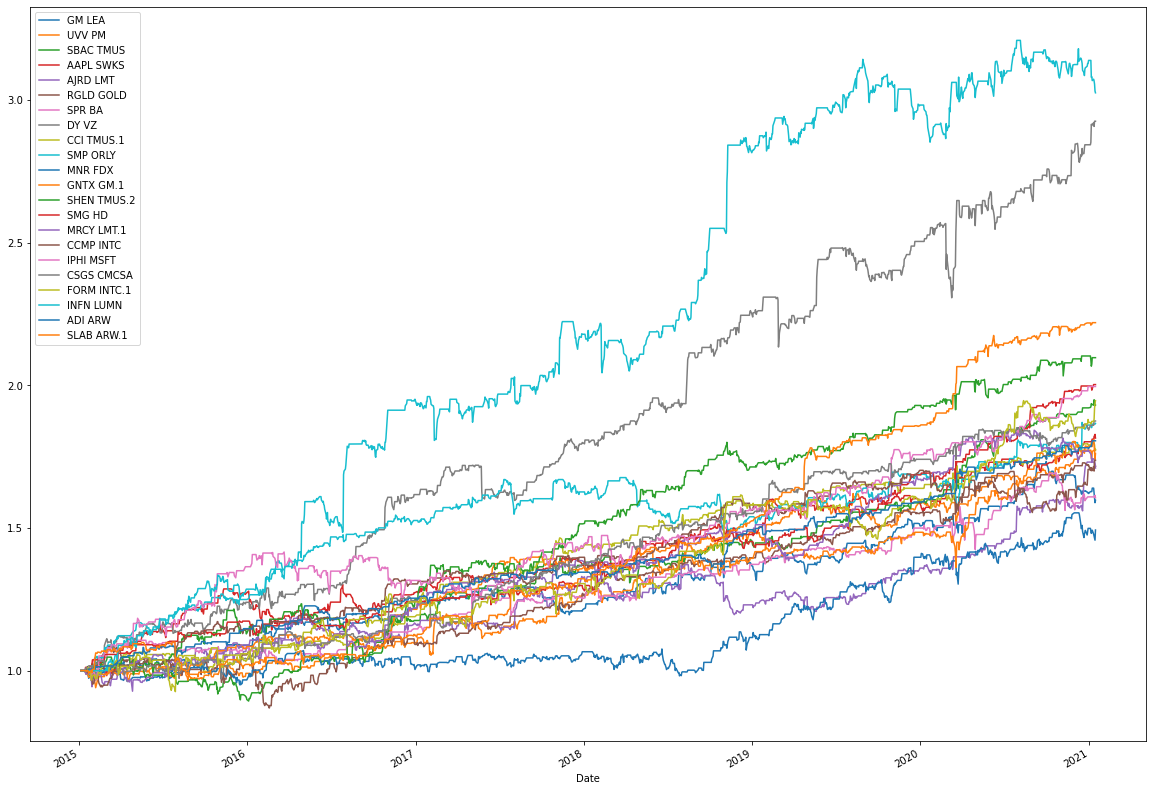

In [33]:
results = []
trades = []

for pair in pairs:
    rets, sharpe, CAGR, trade = backtest(df[[pair[0],pair[1]]],pair[0],pair[1])
    results.append(rets)
    trades.append(trade)
    print("The pair {} and {} produced a Sharpe Ratio of {} and a CAGR of {}".format(pair[0],pair[1],round(sharpe,2),round(CAGR*100,4)))
    rets.plot(figsize=(20,15),legend=True)

#### Делаем равное усреднение каждой из торговой пары, тем самым объединяем результат в торговый портфель:

In [34]:
#concatenate together the individual equity curves into a single DataFrame
results_df = pd.concat(results,axis=1).dropna()

#equally weight each equity curve by dividing each by the number of pairs held in the DataFrame
results_df /= len(results_df.columns)

#sum up the equally weighted equity curves to get our final equity curve
final_res = results_df.sum(axis=1)

#plot the chart of our final equity curve
#with plt.style.context('bmh'):
#    final_res.plot(figsize=(14,8))
 #   plt.title('Pair Trading Portfolio')

In [35]:
#calculate and print our some final stats for our combined equity curve
sharpe = (final_res.pct_change().mean() / final_res.pct_change().std()) * (sqrt(252))
start_val = 1
end_val = final_res.iloc[-1]
start_date = final_res.index[0]
end_date = final_res.index[-1]
days = (end_date - start_date).days
CAGR = round(((float(end_val) / float(start_val)) ** (252.0/days)) - 1,4)
#print("Sharpe Ratio is {} and CAGR is {}".format(round(sharpe,2),round(CAGR*100,4)))

Sharpe Ratio is 5.06 and CAGR is 7.8


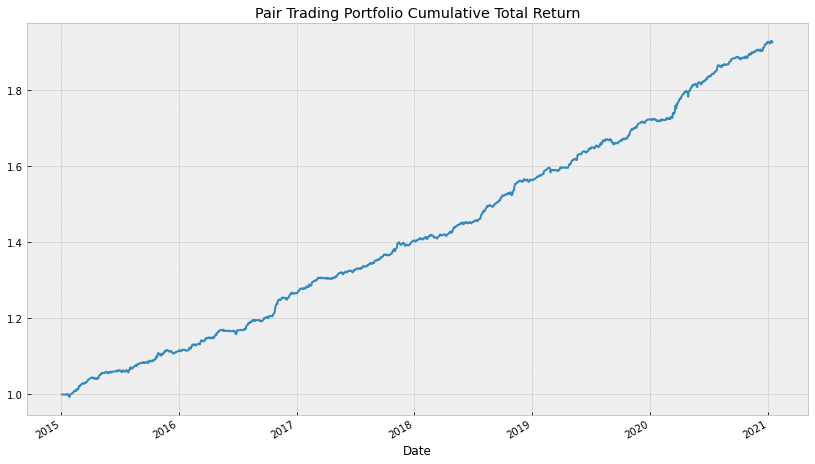

In [36]:
#plot the chart of our final equity curve
print("Sharpe Ratio is {} and CAGR is {}".format(round(sharpe,2),round(CAGR*100,4)))

with plt.style.context('bmh'):
    final_res.plot(figsize=(14,8))
    plt.title('Pair Trading Portfolio Cumulative Total Return')

In [16]:
test.to_csv('test.csv', sep = ';')

#### Получаем данные из InteractiveBrokers, об открытых позициях в портфеле на Демо счете:

In [17]:
def read_positions(): #read all accounts positions and return DataFrame with information

    from ibapi.client import EClient
    from ibapi.wrapper import EWrapper
    from ibapi.common import TickerId
    from threading import Thread

    import pandas as pd
    import time

    class ib_class(EWrapper, EClient):

        def __init__(self, addr, port, client_id):
            EClient.__init__(self, self)

            self.connect(addr, port, client_id) # Connect to TWS
            thread = Thread(target=self.run)  # Launch the client thread
            thread.start()

            self.all_positions = pd.DataFrame([], columns = ['Account','Symbol', 'Quantity', 'Average Cost', 'Sec Type'])

        def error(self, reqId:TickerId, errorCode:int, errorString:str):
            if reqId > -1:
                print("Error. Id: " , reqId, " Code: " , errorCode , " Msg: " , errorString)

        def position(self, account, contract, pos, avgCost):
            index = str(account)+str(contract.symbol)
            self.all_positions.loc[index]= account, contract.symbol, pos, avgCost, contract.secType

    ib_api = ib_class("127.0.0.1", 7497, 10)
    ib_api.reqPositions() # associated callback: position
    print("Waiting for IB's API response for accounts positions requests...\n")
    time.sleep(3.0)
    current_positions = ib_api.all_positions
    current_positions.set_index('Account',inplace=True,drop=True) #set all_positions DataFrame index to "Account"
    ib_api.disconnect()

    return(current_positions)

In [18]:
import ibapi
all_positions = read_positions()

Waiting for IB's API response for accounts positions requests...



In [58]:
from datetime import datetime 
from datetime import timedelta  
print('Today is {} \n'.format((trades[0][-1:].index[0].to_pydatetime() + timedelta(days=1)).date().strftime('%d-%m-%Y')))

order_list = []

Today is 16-01-2021 



#### Пишем алгоритм для выполнения торгового действия: открыть/закрыть позицию или ничего не делать

In [101]:
for i, pair in enumerate(pairs):
    if trades[i][-1:]['long entry'][0] == True:
        
        capital = 10000
        
        single_amount = df[pair[0]][-1:][0] * round(trades[i][-1:]['num units long'][0]) + df[pair[1]][-1:][0] * abs(round(trades[i][-1:]['hr'][0], 2))
        
        weight_x = df[pair[0]][-1:][0] * round(trades[i][-1:]['num units long'][0]) / single_amount
        weight_y = df[pair[1]][-1:][0] * abs(round(trades[i][-1:]['hr'][0], 2)) / single_amount
        
        total_amount_x = weight_x * capital
        total_amount_y = weight_y * capital
        
        quantity_x = total_amount_x / df[pair[0]][-1:][0]
        quantity_y = total_amount_y / df[pair[1]][-1:][0]
        
        order_list.append([pair[0], 'BUY', round(abs(quantity_x))])
        order_list.append([pair[1], 'SELL', round(abs(quantity_y))])
        
        print('You should buy {} units of {} for ${} at {} and sell {} units of {} for ${} at {}'.format(round(quantity_x), 
                                                                       pair[0],
                                                                       round(total_amount_x),
                                                                       df[pair[0]][-1:][0],
                                                                       round(quantity_y),
                                                                       pair[1],
                                                                       round(total_amount_y),
                                                                       df[pair[1]][-1:][0]))
    elif trades[i][-1:]['short entry'][0] == True:
        
        capital = 10000
        
        single_amount = df[pair[0]][-1:][0] * abs(round(trades[i][-1:]['num units short'][0])) + df[pair[1]][-1:][0] * abs(round(trades[i][-1:]['hr'][0], 2))
        
        weight_x = df[pair[0]][-1:][0] * round(trades[i][-1:]['num units short'][0]) / single_amount
        weight_y = df[pair[1]][-1:][0] * abs(round(trades[i][-1:]['hr'][0], 2)) / single_amount
        
        total_amount_x = weight_x * capital
        total_amount_y = weight_y * capital
        
        quantity_x = total_amount_x / df[pair[0]][-1:][0]
        quantity_y = total_amount_y / df[pair[1]][-1:][0]
        
        order_list.append([pair[0], 'SELL', round(abs(quantity_x))])
        order_list.append([pair[1], 'BUY', round(abs(quantity_y))])
        
        print('You should sell {} units of {} for ${} at {} and buy {} units of {} for ${} at {}'.format(round(quantity_x), 
                                                                       pair[0],
                                                                       round(total_amount_x),
                                                                       df[pair[0]][-1:][0],
                                                                       round(quantity_y),
                                                                       pair[1],
                                                                       round(total_amount_y),
                                                                       df[pair[1]][-1:][0]))

        
    elif trades[i][-1:]['long exit'][0] == True:
        try:
            order_list.append([pair[0], 'SELL', abs(all_positions[all_positions['Symbol'] == pair[0].split('.')[0]]['Quantity'][0])])
            order_list.append([pair[1], 'BUY', abs(all_positions[all_positions['Symbol'] == pair[1].split('.')[0]]['Quantity'][0])])
            print('You should close long position on {} {}'.format(pair[0], pair[1]))
        except:
            print('You should close long position on {} {}'.format(pair[0], pair[1]))
    
    elif trades[i][-1:]['short exit'][0] == True:
        try:
            order_list.append([pair[0], 'BUY', abs(all_positions[all_positions['Symbol'] == pair[0].split('.')[0]]['Quantity'][0])])
            order_list.append([pair[1], 'SELL', abs(all_positions[all_positions['Symbol'] == pair[1].split('.')[0]]['Quantity'][0])])
            print('You should close short position on {} {}'.format(pair[0], pair[1]))
        except:
            print('You should close long position on {} {}'.format(pair[0], pair[1]))

You should sell -79.0 units of DY for $-6921.0 at 87.71 and buy 54.0 units of VZ for $3079.0 at 57.38
You should close long position on MNR FDX
You should close long position on SHEN TMUS.2
You should sell -17.0 units of SMG for $-3851.0 at 220.89 and buy 22.0 units of HD for $6149.0 at 275.59
You should sell -7.0 units of MRCY for $-524.0 at 78.37 and buy 27.0 units of LMT.1 for $9476.0 at 347.27
You should close long position on CSGS CMCSA
You should sell -44.0 units of ADI for $-6970.0 at 157.75 and buy 29.0 units of ARW for $3030.0 at 103.89


In [72]:
orders_for_today = pd.DataFrame(order_list, columns = ['ticker', 'order_type', 'quantity'])

In [73]:
for i in range(0, len(orders_for_today['ticker'])):
    orders_for_today['ticker'][i] = orders_for_today['ticker'][i].split('.')[0]

#### Список торговых ордеров на конкретный сегодняшний день:

In [74]:
orders_for_today

,ticker,order_type,quantity
0,DY,SELL,79.0
1,VZ,BUY,54.0
2,SMG,SELL,17.0
3,HD,BUY,22.0
4,MRCY,SELL,7.0
5,LMT,BUY,27.0
6,ADI,SELL,44.0
7,ARW,BUY,29.0


#### Передаем список ордеров в терминал InteractiveBrokers для выполнения:

In [24]:
import ibapi
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.order import Order
from ibapi.contract import Contract

import threading
import time

In [25]:
class IBapi(EWrapper, EClient):
    def __init__(self):
        EClient.__init__(self, self)

    def nextValidId(self, orderId: int):
        super().nextValidId(orderId)
        self.nextorderId = orderId
        print('The next valid order id is: ', self.nextorderId)

    def orderStatus(self, orderId, status, filled, remaining, avgFullPrice, permId, parentId, lastFillPrice, clientId, whyHeld, mktCapPrice):
        print('orderStatus - orderid:', orderId, 'status:', status, 'filled', filled, 'remaining', remaining, 'lastFillPrice', lastFillPrice)
        
    def openOrder(self, orderId, contract, order, orderState):
        print('openOrder id:', orderId, contract.symbol, contract.secType, '@', contract.exchange, ':', order.action, order.orderType, order.totalQuantity, orderState.status)

    def execDetails(self, reqId, contract, execution):
        print('Order Executed: ', reqId, contract.symbol, contract.secType, contract.currency, execution.execId, execution.orderId, execution.shares, execution.lastLiquidity)

In [26]:
def run_loop():
    app.run()

#Function to create Stock Order contract
def Stock_contract(symbol, secType='STK', exchange='SMART', currency='USD'):
    ''' custom function to create stock contract '''
    contract = Contract()
    contract.symbol = symbol
    contract.secType = secType
    contract.exchange = exchange
    contract.currency = currency
    return contract

In [27]:
app = IBapi()
app.connect('127.0.0.1', 7497, 122)
    
app.nextorderId = None
    
#Start the socket in a thread
api_thread = threading.Thread(target=run_loop, daemon=True)
api_thread.start()

while True:
    if isinstance(app.nextorderId, int):
        print('connected')
        break
    else:
        print('waiting for connection')
        time.sleep(1)

for i in range(0, len(orders_for_today)):
    #Create order object
    order = Order()
    order.action = orders_for_today['order_type'][i]
    order.totalQuantity = orders_for_today['quantity'][i]
    order.orderType = 'MKT'
    order.transmit = True
    
    #Place order
    app.placeOrder(app.nextorderId, Stock_contract(orders_for_today['ticker'][i]), order)
    app.nextorderId += 1
        
time.sleep(3)
app.disconnect() 

ERROR -1 2104 Market data farm connection is OK:hfarm
ERROR -1 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 2104 Market data farm connection is OK:eufarm
ERROR -1 2104 Market data farm connection is OK:jfarm
ERROR -1 2104 Market data farm connection is OK:usfuture
ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:euhmds
ERROR -1 2106 HMDS data farm connection is OK:fundfarm
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefnj


waiting for connection
The next valid order id is:  378
connected


unhandled exception in EReader thread
Traceback (most recent call last):
  File "C:\Users\Nikita\.conda\envs\tensorflow\lib\site-packages\ibapi\reader.py", line 34, in run
    data = self.conn.recvMsg()
  File "C:\Users\Nikita\.conda\envs\tensorflow\lib\site-packages\ibapi\connection.py", line 99, in recvMsg
    buf = self._recvAllMsg()
  File "C:\Users\Nikita\.conda\envs\tensorflow\lib\site-packages\ibapi\connection.py", line 119, in _recvAllMsg
    buf = self.socket.recv(4096)
OSError: [WinError 10038] Сделана попытка выполнить операцию на объекте, не являющемся сокетом


### Дополнительно (не используется:) 

In [49]:
app = IBapi()
app.connect('127.0.0.1', 7497, 12553)

app.nextorderId = None

#Start the socket in a thread
api_thread = threading.Thread(target=run_loop, daemon=True)
api_thread.start()

#Check if the API is connected via orderid
while True:
    if isinstance(app.nextorderId, int):
        print('connected')
        break
    else:
        print('waiting for connection')
        time.sleep(1)

#Create order object
order = Order()
order.action = 'BUY'
order.totalQuantity = 100
order.orderType = 'MKT'
order.transmit = True

#Place order
app.placeOrder(app.nextorderId, Stock_contract('AAPL'), order)
app.nextorderId += 1

time.sleep(3)
app.disconnect()

ERROR -1 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:euhmds
ERROR -1 2106 HMDS data farm connection is OK:cashhmds
ERROR -1 2106 HMDS data farm connection is OK:fundfarm
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefnj


waiting for connection
The next valid order id is:  6


ERROR 6 354 You are trying to submit an order without having market data for this instrument.
IB strongly recommends against this kind of blind trading
which may result in erroneous or unexpected trades.
Restriction is specified in Precautionary Settings of Global Configuration/Presets.


connected


unhandled exception in EReader thread
Traceback (most recent call last):
  File "C:\Users\Nikita\.conda\envs\tensorflow\lib\site-packages\ibapi\reader.py", line 34, in run
    data = self.conn.recvMsg()
  File "C:\Users\Nikita\.conda\envs\tensorflow\lib\site-packages\ibapi\connection.py", line 99, in recvMsg
    buf = self._recvAllMsg()
  File "C:\Users\Nikita\.conda\envs\tensorflow\lib\site-packages\ibapi\connection.py", line 119, in _recvAllMsg
    buf = self.socket.recv(4096)
OSError: [WinError 10038] Сделана попытка выполнить операцию на объекте, не являющемся сокетом


In [52]:
#Function to create FX Order contract
def FX_order(symbol):
    contract = Contract()
    contract.symbol = symbol[:3]
    contract.secType = 'CASH'
    contract.exchange = 'IDEALPRO'
    contract.currency = symbol[3:]
    return contract

app = IBapi()
app.connect('127.0.0.1', 7497, 12553)

app.nextorderId = None

#Start the socket in a thread
api_thread = threading.Thread(target=run_loop, daemon=True)
api_thread.start()

#Check if the API is connected via orderid
while True:
    if isinstance(app.nextorderId, int):
        print('connected')
        break
    else:
        print('waiting for connection')
        time.sleep(1)

#Create order object
order = Order()
order.action = 'BUY'
order.totalQuantity = 10000
order.orderType = 'MKT'

#Place order
app.placeOrder(app.nextorderId, FX_order('EURUSD'), order)
#app.nextorderId += 1

time.sleep(3)
app.disconnect()

ERROR -1 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:euhmds
ERROR -1 2106 HMDS data farm connection is OK:cashhmds
ERROR -1 2106 HMDS data farm connection is OK:fundfarm
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefnj


waiting for connection
The next valid order id is:  8
connected


ERROR 8 399 Order Message:
BUY 10K EUR.USD Forex


openOrder id: 8 EUR CASH @ IDEALPRO : BUY MKT 10000.0 PreSubmitted
orderStatus - orderid: 8 status: PreSubmitted filled 0.0 remaining 10000.0 lastFillPrice 0.0
openOrder id: 8 EUR CASH @ IDEALPRO : BUY MKT 10000.0 Submitted
orderStatus - orderid: 8 status: Submitted filled 0.0 remaining 10000.0 lastFillPrice 0.0
Order Executed:  -1 EUR CASH USD 0000e215.5f615872.01.01 8 10000.0 2
openOrder id: 8 EUR CASH @ IDEALPRO : BUY MKT 10000.0 Filled
orderStatus - orderid: 8 status: Filled filled 10000.0 remaining 0.0 lastFillPrice 1.18285
openOrder id: 8 EUR CASH @ IDEALPRO : BUY MKT 10000.0 Filled
orderStatus - orderid: 8 status: Filled filled 10000.0 remaining 0.0 lastFillPrice 1.18285


unhandled exception in EReader thread
Traceback (most recent call last):
  File "C:\Users\Nikita\.conda\envs\tensorflow\lib\site-packages\ibapi\reader.py", line 34, in run
    data = self.conn.recvMsg()
  File "C:\Users\Nikita\.conda\envs\tensorflow\lib\site-packages\ibapi\connection.py", line 99, in recvMsg
    buf = self._recvAllMsg()
  File "C:\Users\Nikita\.conda\envs\tensorflow\lib\site-packages\ibapi\connection.py", line 119, in _recvAllMsg
    buf = self.socket.recv(4096)
OSError: [WinError 10038] Сделана попытка выполнить операцию на объекте, не являющемся сокетом
